In [57]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langgraph.graph.message import add_messages

#from langgraph import user_input


In [58]:
import os
from dotenv import load_dotenv

#Loading Keys from .env file
load_dotenv()
groq_api_key = os.getenv("GROQ")

In [59]:
  #Working with the tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [60]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [62]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [64]:
tools=[wiki_tool]

In [65]:
class State(TypedDict):
     messages:Annotated[list, add_messages]

In [66]:
from langgraph.graph import StateGraph, START, END
graph_builder= StateGraph(State)

In [67]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BDC366FBD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BDC448D8C0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [68]:
llm_with_tools = llm.bind_tools(tools=tools)

In [69]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [70]:
from langgraph.prebuilt import ToolNode, tools_condition

In [81]:
#graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

tool_node = ToolNode(tools=tools)
#graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `tools_condition` already exists for node `chatbot`

In [82]:
graph=graph_builder.compile()

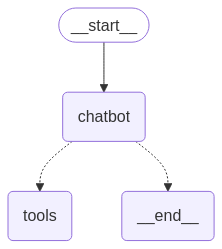

In [85]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [87]:
user_input="Hi there, My name is John"
events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9e9j)
 Call ID: call_9e9j
  Args:
    query: John
================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found


C:\Users\Aryan\Documents\Projects\LangGraph\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Aryan\Documents\Projects\LangGraph\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
